## The data grabbed from UHF antenna

The Parallella (Pcko) grabbing unit was used to capture triggered data from loop antennas.

In [ ]:
# Tato bunka slouzi pro papermill, je oznacena tagem 'parameters'

path = "/storage/experiments/2022/0806_bourka_zdiby/parallella-VLF/"
path = "/storage/experiments/2022/0815_bourka_SlanyMelnik_CAR2/parallella/"
path = "/storage/experiments/2022/0815_bourka_kralupy_CAR0/parallella-VLF/"
path = "/storage/experiments/2022/0815_bourka_benesov_CAR1/parallella/"
path = "/storage/experiments/2022/0816_test_STP_gain/"
path = "/storage/experiments/2022/0825_bourka_D8_19km_CAR2/parallella-VLF"
path = "/storage/experiments/2022/0825_bourka_D8_1km_CAR1/parallella/"
path = "/storage/experiments/2022/0825_bourka_D8_9km_CAR0/parallella-VLF/"
path = "/storage/experiments/2022/0826_bourka_staryvestec_CAR2/parallella-VLF/"
path = "/storage/experiments/2022/0826_bourka_staryvestec_CAR0/parallella-VLF/"
path = "/storage/experiments/2022/0826_bourka_staryvestec_CAR1/parallella/"
path = "/storage/experiments/2022/0827_bourka_morava_CAR0/parallella-VLF/"
#path = "/storage/experiments/2022/0827_bourka_morava_CAR0/parallella-VLF"
#path = "/storage/experiments/2022/0805_bourka_kourim/parallella-VLF/"
#path = "/storage/experiments/2022/0714_bourka_horovice_CAR1/parallella/"

In [ ]:
import os
import sys
#sys.path.append('..')
#from QFH_lightning.readrec import *
from readrec import *
import matplotlib
from scipy.signal import find_peaks
import datetime


sps = 10e6 # 10 Msps
files = os.listdir(path)
times = []

for fn in files:
    with open(os.path.join(path, fn), 'rb') as f:
        if "png" not in fn and "csv" not in fn:
            try:
                trigger_time = datetime.datetime.strptime(fn[4:]+"0000", "%y%m%d-%H%M%S.%f")
                times.append([path+fn, str(trigger_time)])
                #h, samples, synclog = loadrec(f, skipsamples=True)
            except Exception as e:
                print(fn, e)
                continue

print("Budou se pouzivat soubory", files)
print("Ze slozky", path)


with open(path+'/../triggers.csv', 'w') as f:
    for t in times:
        f.writelines(";".join(t)+";\n")

## Plotting of the data

In [ ]:
import os
pre_trigger_blocks = 380
post_trigger_blocks = 380


pre_trigger_blocks = 100
post_trigger_blocks = 100


matplotlib.rcParams.update({'font.size':15})

for fn in reversed(files):
    print(fn)
    if ".csv" in files:
        continue
    with open(os.path.join(path, fn), 'rb') as f:
        try:
            print("File:", fn)
            h, samples, synclog = loadrec(f)
            t2s, s2t, ticker, formatter = assign_time_axis(fn, h, synclog)
            #print("SYNCLOG", synclog)
            for s in synclog:
                print(s[1], s[0], s2t(s[0]))
            #print(edges((h, samples, synclog)) )
            fig = selective_plotrec(h, samples, synclog, os.path.basename(fn),
                    title=os.path.basename(fn),
                    pre_trigger_blocks = pre_trigger_blocks,
                    post_trigger_blocks = post_trigger_blocks,
                    marktimes=ticker,
                    channels = [0,1,3],
                    #channels = [0,1,2,3,4,5,6,7]
                    )
            
            plt.tight_layout()
            try:
                plt.savefig(os.path.join(path, fn)+'.png')
                pass
            except Exception as e:
                print(e)
            #plt.savefig('/home/roman/VLF.png')
            plt.show()
   
        except Exception as e:
            print(e)

In [ ]:
a = pd.DataFrame(synclog).sort_values(["f", "w"]).reset_index()
a["w"] = a["w"].diff()
a

Plot all lightning records (High memory and time consuming)

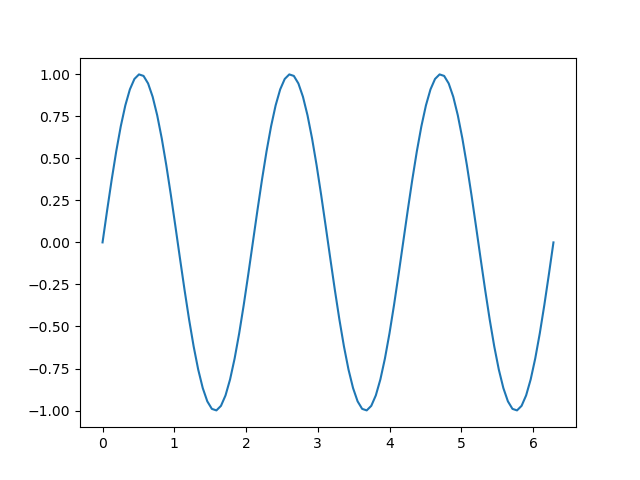

In [1]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()


x = np.linspace(0, 2*np.pi, 100)
y = np.sin(3*x)
ax.plot(x, y)


## Convert record to an pandas dataframe with exact timestamp for the each sample. 

In [1]:
import re
import os
import pandas as pd
from readrec import loadrec, assign_time_axis  # Ensure this import is at the top of your file

def extract_signal_with_datetime(files, selected_channels, sps):
    fragments = []
    id_to_station = {}

    for filepath in files:
        try:
            car_match = re.search(r'CAR(\d+)', filepath)
            if car_match:
                station_id = car_match.group(1)
            else:
                raise ValueError("Station identifier not found in the file path.")
                
            with open(filepath, 'rb') as file:
                fn = os.path.basename(filepath)
                h, samples, synclog = loadrec(file)  # Use actual loadrec function
                t2s, s2t, _, _ = assign_time_axis(fn, h, synclog)  # Use actual assign_time_axis function

                # Use the s2t function to create timestamps for all samples
                timestamps = pd.date_range(start=s2t(0), periods=samples.shape[0], freq=pd.to_timedelta(1/sps, unit='s'))
                combined_data = pd.DataFrame(samples[:, selected_channels], index=timestamps, columns=[f'Channel_{ch}' for ch in selected_channels])

                fragments.append(('CAR' + station_id + '_' + fn, combined_data))
                id_to_station['CAR' + station_id + '_' + fn] = 'CAR' + station_id

        except Exception as e:
            print(f"Error processing file {filepath}: {e}")
    
    return fragments, id_to_station


In [2]:
files = ['/storage/experiments/2022/0826_bourka_staryvestec_CAR2/parallella-VLF/rec_220826-163022.70',
         '/storage/experiments/2022/0826_bourka_staryvestec_CAR0/parallella-VLF/rec_220826-163022.43',
         '/storage/experiments/2022/0826_bourka_staryvestec_CAR1/parallella/rec_220826-163022.62']

sps = 10e6 # 10 Msps

In [3]:
selected_channels = [0, 1, 3] # Selection of channels with antenna connected

fragments, id_to_station = extract_signal_with_datetime(files, selected_channels, sps)


In [4]:
fragments

[('CAR2_rec_220826-163022.70',
                                 Channel_0  Channel_1  Channel_3
  2022-08-26 16:30:21.320639100       -336        112        -64
  2022-08-26 16:30:21.320639200       -240        112        112
  2022-08-26 16:30:21.320639300        112        112       -208
  2022-08-26 16:30:21.320639400       -160         96       -160
  2022-08-26 16:30:21.320639500       -256        112       -112
  ...                                  ...        ...        ...
  2022-08-26 16:30:22.782091400        -80         16       -128
  2022-08-26 16:30:22.782091500       -144          0        -48
  2022-08-26 16:30:22.782091600          0         48        -96
  2022-08-26 16:30:22.782091700       -160         64        -48
  2022-08-26 16:30:22.782091800       -160         32       -128
  
  [14614528 rows x 3 columns]),
 ('CAR0_rec_220826-163022.43',
                                 Channel_0  Channel_1  Channel_3
  2022-08-26 16:30:21.050932000        384       -336     

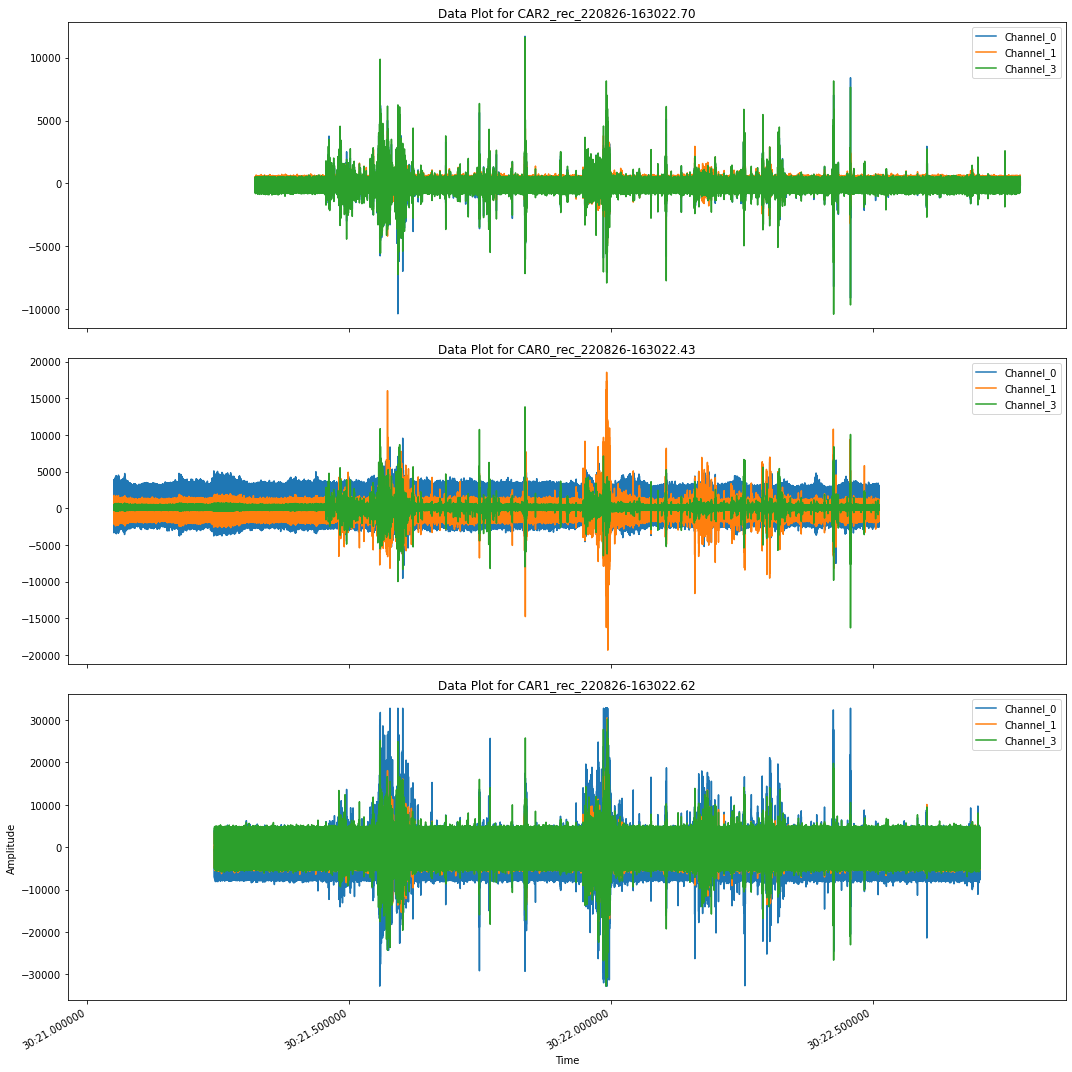

In [8]:
import matplotlib.pyplot as plt

def plot_fragments_shared_axis(fragments):
    # Vytvoření figure a nastavení velikosti
    fig, axs = plt.subplots(len(fragments), 1, figsize=(15, 5 * len(fragments)), sharex=True)

    # Zkontrolujte, jestli axs je iterable (v případě, že je pouze jeden fragment)
    if len(fragments) == 1:
        axs = [axs]

    # Iterace přes každý fragment
    for ax, (label, data) in zip(axs, fragments):
        for channel in data.columns:
            ax.plot(data.index, data[channel], label=channel)
        ax.set_title(f"Data Plot for {label}")
        ax.legend()

    # Nastavení společných os pro všechny subplots
    for ax in axs:
        ax.label_outer()  # Skryje x-labels a tick labels na vnitřních grafech

    fig.autofmt_xdate()  # Auto-format date labels
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_fragments_shared_axis(fragments)
